In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import corner
from tqdm import trange
from sklearn.model_selection import cross_val_score, KFold, train_test_split

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

In [2]:
data_df = pd.read_excel("../data/credit_card.xls", header=1)
data_df.rename(columns = {"PAY_0":'PAY_1'}, inplace = True)
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [3]:
data_df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

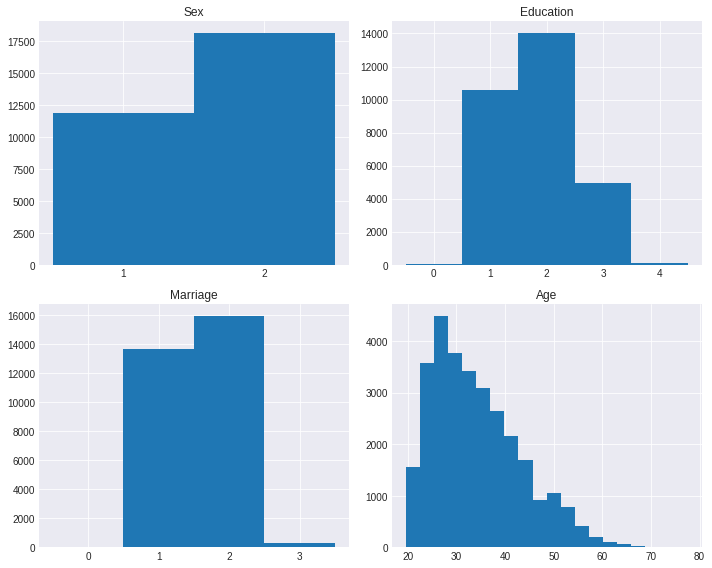

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].hist(data_df["SEX"], bins=np.arange(0.5, 3), align="mid")
ax[0,1].hist(data_df["EDUCATION"], bins=np.arange(-0.5, 5), align="mid")
ax[1,0].hist(data_df["MARRIAGE"], bins=np.arange(-0.5, 4), align="mid")
ax[1,1].hist(data_df["AGE"], bins=20, align="left");

ax[0,0].set_title("Sex")
ax[0,1].set_title("Education")
ax[1,0].set_title("Marriage")
ax[1,1].set_title("Age")

ax[0,0].set_xticks([1, 2])# ax[0,0].set_xticklabels(["Male", "Female"])
ax[0,1].set_xticks([0, 1, 2, 3, 4])#, ax[0,1].set_xticklabels(["NULL", "Grad School", "University", "High School", "Other"], rotation=45);
ax[1,0].set_xticks([0, 1, 2, 3]);
plt.tight_layout()

100%|██████████| 6/6 [00:17<00:00,  2.50s/it]


19766

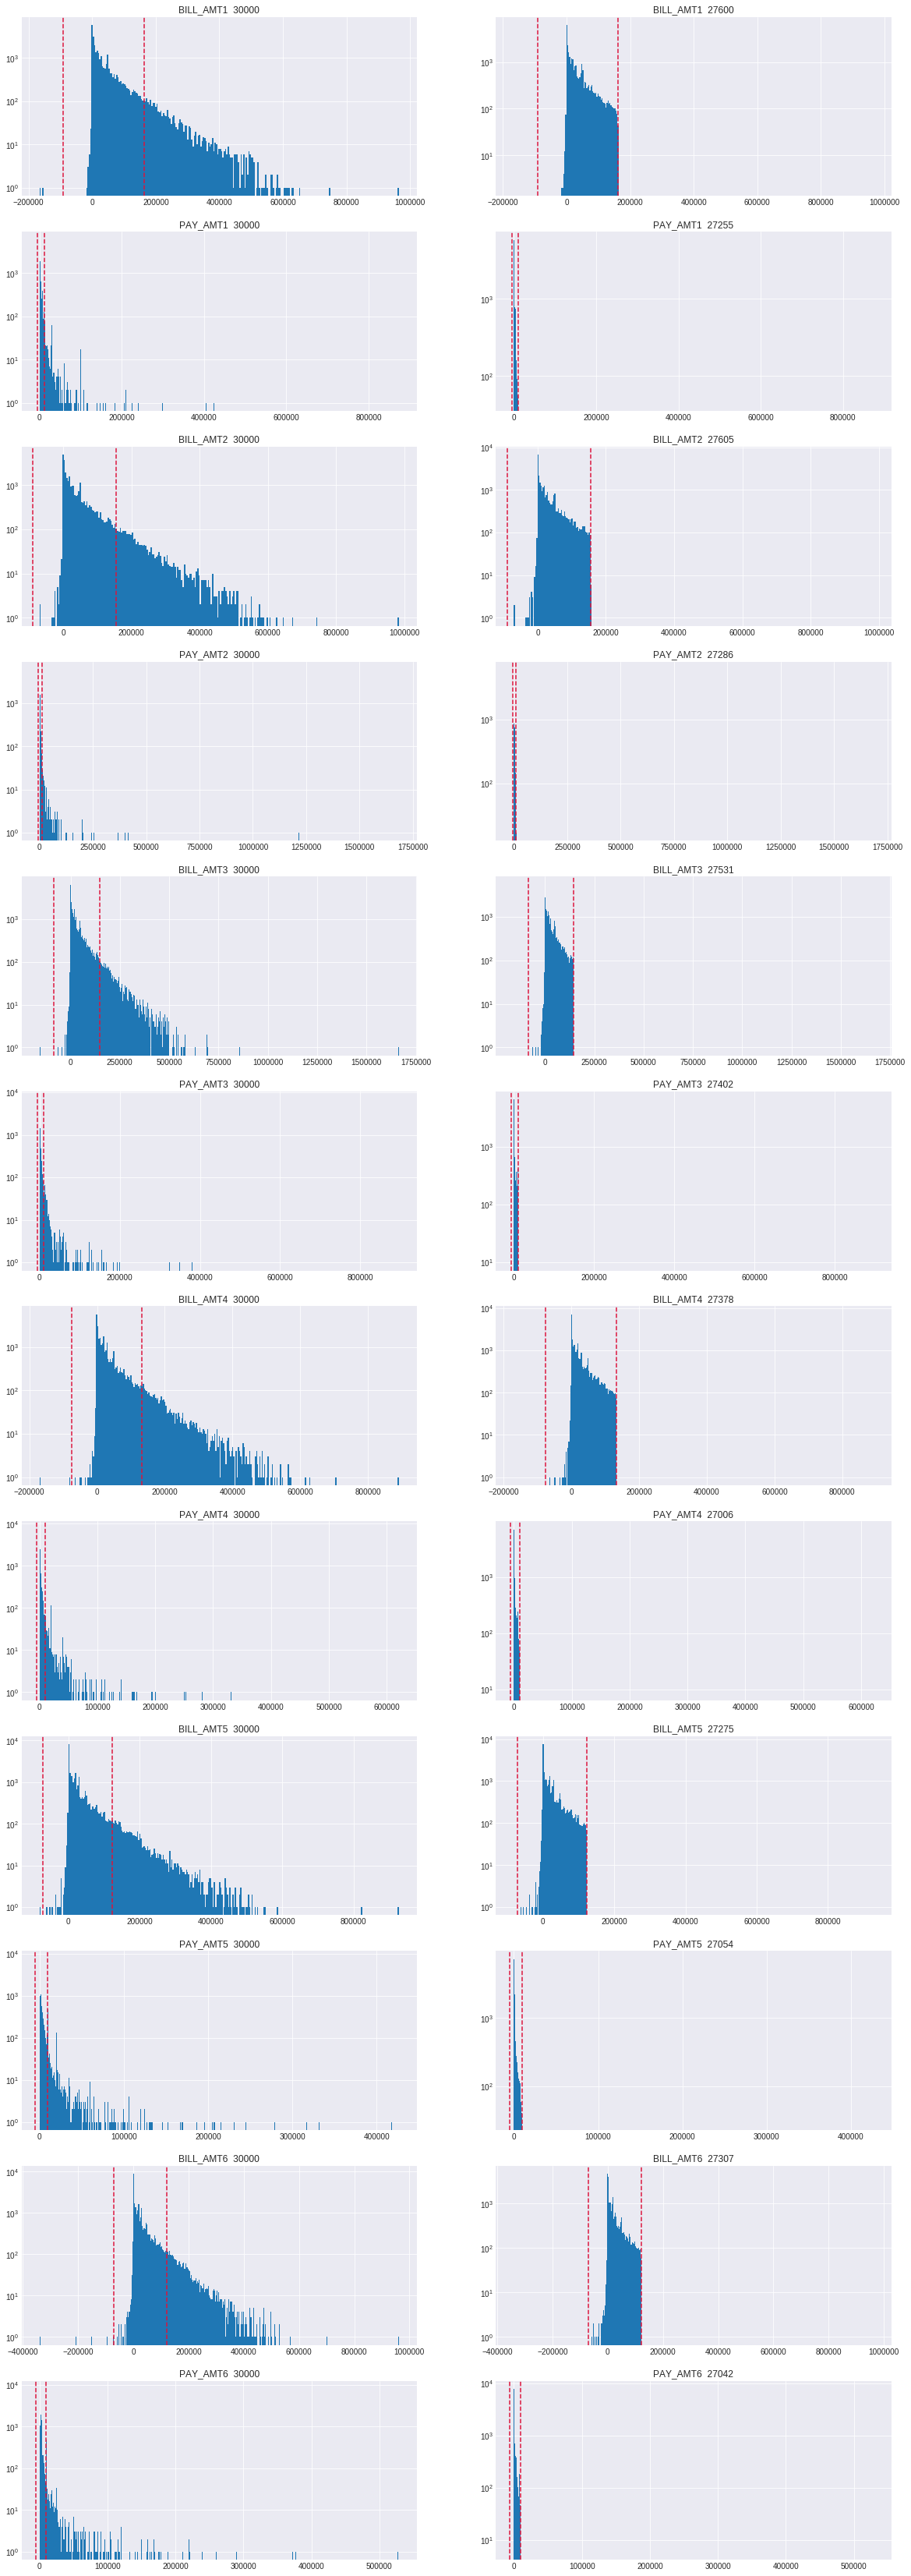

In [5]:
fig, ax = plt.subplots(12, 2, figsize=(20, 60))
cut_indexes = np.ones(len(data_df), dtype=bool)

for i in trange(1, 7):
    for j, datatype in enumerate(["BILL_AMT", "PAY_AMT"]):
        current_cut_indexes = np.ones(len(data_df), dtype=bool)

        dataname = datatype + str(i)
        xlim = (data_df[dataname].min(), data_df[dataname].max())
        ax[(i-1)*2 + j, 0].hist(data_df[dataname], bins="auto", log=True, range=xlim)
        
        Q1 = np.quantile(data_df[dataname], 0.25)
        Q3 = np.quantile(data_df[dataname], 0.75)
        IQR = Q3 - Q1
        current_cut_indexes = (data_df[dataname] < Q3 + 1.5*IQR)&(data_df[dataname] > Q1 - 1.5*IQR)

        ax[(i-1)*2 + j, 1].hist(data_df[dataname][current_cut_indexes], bins="auto", log=True, range=xlim)
        
        ax[(i-1)*2 + j, 0].axvline(x = Q1-1.5*IQR, c="crimson", ls="--")
        ax[(i-1)*2 + j, 0].axvline(x = Q3+1.5*IQR, c="crimson", ls="--")
        
        ax[(i-1)*2 + j, 1].axvline(x = Q1-1.5*IQR, c="crimson", ls="--")
        ax[(i-1)*2 + j, 1].axvline(x = Q3+1.5*IQR, c="crimson", ls="--")
        
        ax[(i-1)*2 + j, 0].set_title(f"{datatype + str(i)}  {len(data_df)}")
        ax[(i-1)*2 + j, 1].set_title(f"{datatype + str(i)}  {np.sum(current_cut_indexes)}")
        
        cut_indexes = cut_indexes&current_cut_indexes

data_df = data_df[cut_indexes]
data_df = data_df.reset_index(drop=True)
len(data_df)

19041

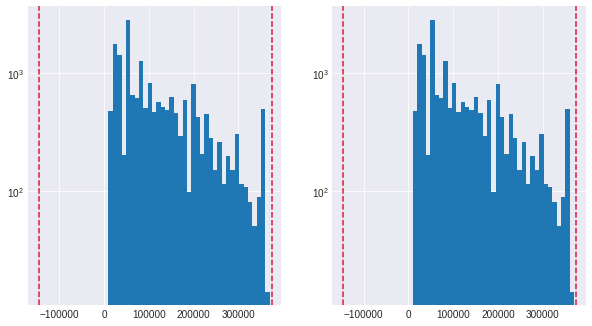

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5.5))
ax[0].hist(data_df["LIMIT_BAL"], bins="auto", log=True)
Q1 = np.quantile(data_df["LIMIT_BAL"], 0.25)
Q3 = np.quantile(data_df["LIMIT_BAL"], 0.75)
IQR = Q3 - Q1
data_df = data_df[data_df["LIMIT_BAL"] < Q3 + 1.5*IQR]
data_df = data_df[data_df["LIMIT_BAL"] > Q1 - 1.5*IQR]
ax[1].hist(data_df["LIMIT_BAL"], bins="auto", log=True)
ax[0].axvline(Q1-1.5*IQR, ls="--", c="crimson")
ax[0].axvline(Q3+1.5*IQR, ls="--", c="crimson")
ax[1].axvline(Q1-1.5*IQR, ls="--", c="crimson")
ax[1].axvline(Q3+1.5*IQR, ls="--", c="crimson")
len(data_df)

In [9]:
data_df.to_pickle("../data/credit_card_cleaned.pickle")
data_df = pd.read_pickle("../data/credit_card_cleaned.pickle")

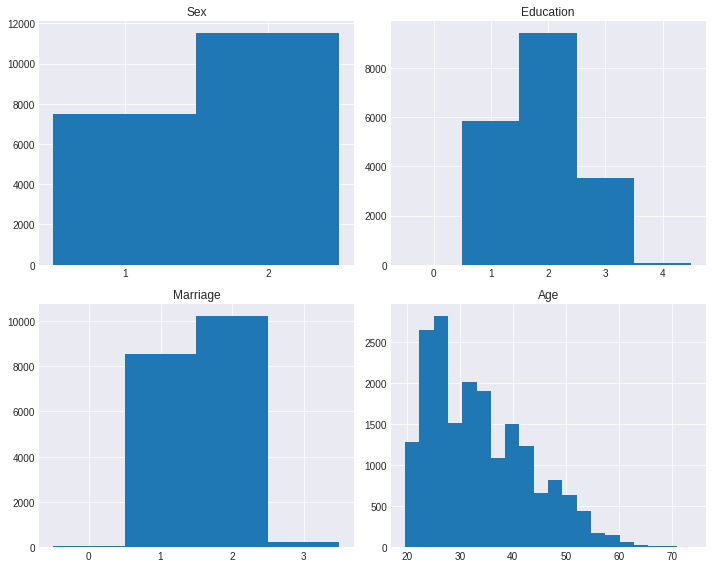

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].hist(data_df["SEX"], bins=np.arange(0.5, 3), align="mid")
ax[0,1].hist(data_df["EDUCATION"], bins=np.arange(-0.5, 5), align="mid")
ax[1,0].hist(data_df["MARRIAGE"], bins=np.arange(-0.5, 4), align="mid")
ax[1,1].hist(data_df["AGE"], bins=20, align="left");

ax[0,0].set_title("Sex")
ax[0,1].set_title("Education")
ax[1,0].set_title("Marriage")
ax[1,1].set_title("Age")

ax[0,0].set_xticks([1, 2])# ax[0,0].set_xticklabels(["Male", "Female"])
ax[0,1].set_xticks([0, 1, 2, 3, 4])#, ax[0,1].set_xticklabels(["NULL", "Grad School", "University", "High School", "Other"], rotation=45);
ax[1,0].set_xticks([0, 1, 2, 3]);
plt.tight_layout()